______

<div align='center'><h2>Hackathon</h2>
<h4>Quelles énergies pour demain ?</h4>  
</div>
Vendredi 22 novembre 2019  
Camille COCHENER, Romain LEGRAND, Sophie LEVEUGLE, Rodolphe SIMONEAU, Hélène DANLOS
______


**Importation des librairies**

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wbpy
from pprint import pprint
import numpy as np
from numpy.linalg import inv
import math
import datetime
import geopandas as gpd

<h3>1. Importation des données</h3>

Jeux de données utilisés :
* Statistical Review of World Energy, site BP. Jeu de données exploitable et propre. Nous y avons récupérer toutes les informations de consommations et de productions par région et par source d'énergie.
* Données issues de la World Bank de l'application Climate Data API. Nous avons récupéré les températures annuelles de 1890 à 2012. Une des rares à avoir des données historiques.
* NASA Globale Climate Change Database : relevé de déviations de température jusqu'à 2019 utilisé pour les prévisions. 
* Dataset IEA (International Energy Agency) : elle recense pour ses états membres les dépenses en R&D par type de technologie depuis 1976. 

In [88]:
url = 'https://www.bp.com/content/dam/bp/business-sites/en/global/corporate/xlsx/energy-economics/statistical-review/bp-stats-review-2019-consolidated-dataset-panel-format.csv'
databp = pd.read_csv(url)

In [89]:
crude_oil_price = pd.read_excel('https://www.bp.com/content/dam/bp/business-sites/en/global/corporate/xlsx/energy-economics/statistical-review/bp-stats-review-2019-all-data.xlsx', sheet_name='Oil - Crude prices since 1861', skiprows=3)

<h3>2. Préparation des données</h3>

In [90]:
crude_oil_price = crude_oil_price.iloc[:,:3]
databp_price = databp.merge(crude_oil_price, on = 'Year', how='left' )
databp_price.head()

,Country,Year,pop,ISO3166_alpha3,ISO3166_numeric,Region,SubRegion,OPEC,EU,OECD,...,refcap_kbd,refthru_kbd,renewables_mtoe,renewables_twh,solar_mtoe,solar_twh,wind_mtoe,wind_twh,$ money of the day,$ 2018
0,Algeria,1965,12.626952,DZA,12.0,Africa,Northern Africa,1.0,0.0,0.0,...,54.221918,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.8,14.310086
1,Algeria,1966,12.980267,DZA,12.0,Africa,Northern Africa,1.0,0.0,0.0,...,54.221918,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.8,13.921372
2,Algeria,1967,13.354197,DZA,12.0,Africa,Northern Africa,1.0,0.0,0.0,...,54.221918,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.8,13.528139
3,Algeria,1968,13.744387,DZA,12.0,Africa,Northern Africa,1.0,0.0,0.0,...,54.221918,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.8,12.985747
4,Algeria,1969,14.144438,DZA,12.0,Africa,Northern Africa,1.0,0.0,0.0,...,54.221918,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.8,12.321318


In [91]:
list_columns = ['Country', 'Year', 'pop', 'Region', 'co2_mtco2', 'coalcons_mtoe', 'coalprod_mtoe', 'gascons_mtoe', 'gasprod_mtoe', 'hydro_mtoe', 'hydro_twh', 'nuclear_mtoe',
                'nuclear_twh', 'oilcons_mtoe', 'oilprod_mt', 'primary_gj_pc', 'primary_mtoe', 'renewables_mtoe', 'renewables_twh', 'solar_mtoe', 'solar_twh', 'wind_mtoe', 'wind_twh', '$ 2018']

In [92]:
databp = databp_price[list_columns]

In [93]:
databp = databp[databp['Country'].str.startswith('Total')]
databp = databp[databp['Country'].isin(['Total Africa', 'Total Europe', 'Total North America',
                                        'Total S. & Cent. America', 'Total Asia Pacific', 'Total CIS', 'Total Middle East', 'Total World'])]

Comparaison des sommes des variables dans le monde et sur toutes les régions (pour vérifier)

In [94]:
table = databp[databp['Country'] != 'Total World']
table.groupby('Year').sum().tail()

,pop,co2_mtco2,coalcons_mtoe,coalprod_mtoe,gascons_mtoe,gasprod_mtoe,hydro_mtoe,hydro_twh,nuclear_mtoe,nuclear_twh,...,oilprod_mt,primary_gj_pc,primary_mtoe,renewables_mtoe,renewables_twh,solar_mtoe,solar_twh,wind_mtoe,wind_twh,$ 2018
Year,,,,,,,,,,,,,,,,,,,,,
2014,7300.110081,32844.804431,3864.189770,3965.958617,2917.145679,2950.199175,878.658515,3883.143443,574.908934,2540.752541,...,4223.177081,794.962629,12939.768027,319.523267,1412.101125,44.782212,197.910508,161.115015,712.031697,734.667505
2015,7384.692614,32804.420136,3768.952125,3860.850460,2980.628459,3010.910035,878.946770,3884.417357,582.784225,2575.556604,...,4354.823310,790.409006,13045.577227,368.509293,1628.589970,58.998782,260.739219,188.121579,831.384507,388.507040
2016,7468.674381,32913.541033,3710.047235,3660.803192,3052.611733,3045.305678,909.115213,4017.743774,591.764049,2615.242039,...,4367.980221,792.245246,13228.584124,416.770379,1841.875013,74.303778,328.378115,216.516618,956.873542,320.297714
2017,7551.997557,33242.522006,3718.440181,3754.989520,3141.892350,3162.287106,919.908387,4065.443127,597.135854,2638.982195,...,4379.862350,795.255493,13474.602169,490.221087,2166.483071,102.619735,453.517658,255.235911,1127.989587,388.612549
2018,7634.579073,33887.738745,3772.096014,3916.782110,3309.421395,3325.761770,948.794893,4193.104151,611.266687,2701.431999,...,4474.326494,808.131897,13864.882687,561.250318,2480.389654,132.287396,584.630918,287.358776,1269.953375,499.170418


In [95]:
databp.tail()

,Country,Year,pop,Region,co2_mtco2,coalcons_mtoe,coalprod_mtoe,gascons_mtoe,gasprod_mtoe,hydro_mtoe,...,oilprod_mt,primary_gj_pc,primary_mtoe,renewables_mtoe,renewables_twh,solar_mtoe,solar_twh,wind_mtoe,wind_twh,$ 2018
5893,Total World,2014,7300.110081,NaN,32844.80444,3864.189771,3965.958617,2917.145679,2950.199175,878.658515,...,4223.177081,74.212882,12939.76803,319.523267,1412.101125,44.782212,197.910508,161.115015,712.031697,104.952501
5894,Total World,2015,7384.692614,NaN,32804.42013,3768.952124,3860.850460,2980.628459,3010.910035,878.946770,...,4354.823310,73.962757,13045.57723,368.509293,1628.589970,58.998782,260.739219,188.121579,831.384507,55.501006
5895,Total World,2016,7468.674381,NaN,32913.54103,3710.047235,3660.803193,3052.611733,3045.305678,909.115213,...,4367.980221,74.156983,13228.58412,416.770379,1841.875013,74.303778,328.378114,216.516618,956.873542,45.756816
5896,Total World,2017,7551.997557,NaN,33242.52200,3718.440181,3754.989520,3141.892350,3162.287106,919.908388,...,4379.862350,74.702705,13474.60217,490.221087,2166.483071,102.619735,453.517658,255.235911,1127.989587,55.516078
5897,Total World,2018,7634.579073,NaN,33887.73875,3772.096014,3916.782110,3309.421395,3325.761770,948.794893,...,4474.326494,76.034959,13864.88269,561.250318,2480.389654,132.287396,584.630918,287.358776,1269.953375,71.310060


Nous avons bien les mêmes nombres.

In [96]:
databp['Year'] = databp['Year'].apply(str)
databp['Year'] = pd.to_datetime(databp['Year'], format='%Y')

<h1>I. Etat des lieux</h1>

<h2>A) Etat des lieux de la consommation et de la production des énergies dans le monde</h2>

<h4>a) Evolution de la population par région mondiale depuis 1965</h4>

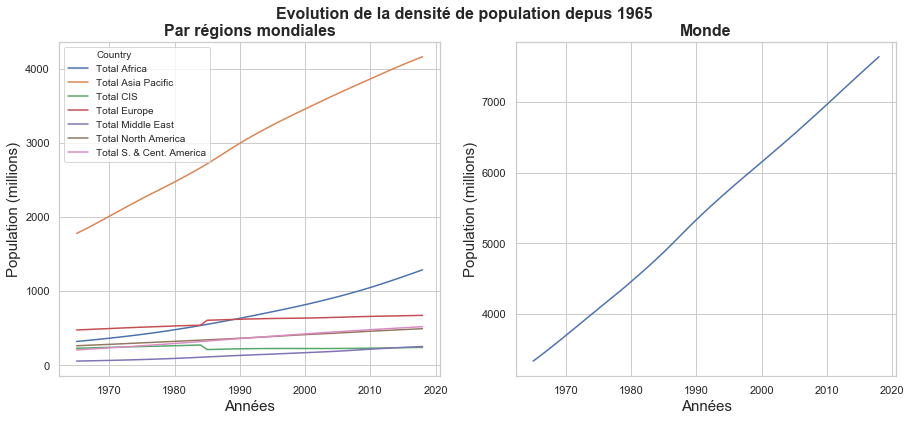

In [97]:
plt.close("all")
fig = plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=0.90)
plt.suptitle('Evolution de la densité de population depus 1965',
             fontweight='bold', fontsize=16)
plt.subplot(121)
sns.set(style='whitegrid')
sns.lineplot(x="Year", y="pop", hue="Country", data=table)
plt.title("Par régions mondiales", fontsize=16, fontweight='bold')
plt.xlabel("Années", fontsize=15)
plt.ylabel("Population (millions)", fontsize=15)
plt.legend(loc='upper left', prop={'size': 10})
plt.subplot(122)
sns.set(style='whitegrid',)
sns.lineplot(x="Year", y="pop", hue="Country",
             data=databp[databp['Country'] == 'Total World'])
plt.title("Monde", fontsize=16, fontweight='bold')
plt.xlabel("Années", fontsize=15)
plt.ylabel("Population (millions)", fontsize=15)
plt.legend().set_visible(False)
plt.show()

<h4>b) Evolution de la consommation des énergies par région mondiale depuis 1965</h4>

In [98]:
list_energies = ['Country', 'Year', 'coalcons_mtoe', 'gascons_mtoe', 'hydro_mtoe',
                 'nuclear_mtoe', 'oilcons_mtoe', 'primary_mtoe', 'renewables_mtoe', 'solar_mtoe', 'wind_mtoe']

In [99]:
conso_energies = databp[list_energies]
conso_energies.rename(columns={'coalcons_mtoe': 'Coal', 'gascons_mtoe': 'Gas', 'hydro_mtoe': 'Hydraulic', 'nuclear_mtoe': 'Nuclear',
                               'oilcons_mtoe': 'Oil', 'primary_mtoe': 'Primary', 'renewables_mtoe': 'Renewables', 'solar_mtoe': 'Solar', 'wind_mtoe': 'Wind'}, inplace=True)
conso_energies = conso_energies.melt(id_vars=['Country', 'Year'])

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


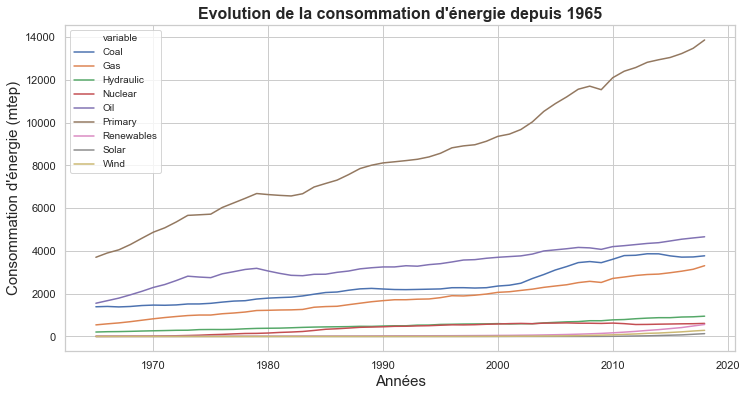

In [100]:
plt.close("all")
fig = plt.figure(figsize=(12, 6))
sns.set(style='whitegrid')
sns.lineplot(x="Year", y="value", hue='variable',
             data=conso_energies[conso_energies['Country'] == 'Total World'])
plt.title("Evolution de la consommation d'énergie depuis 1965",
          fontsize=16, fontweight='bold')
plt.xlabel("Années", fontsize=15)
plt.ylabel("Consommation d'énergie (mtep)", fontsize=15)
plt.legend(loc='upper left', prop={'size': 10})
plt.show()

<h4>c) Evolution de la production des énergies par région mondiale depuis 1965</h4>

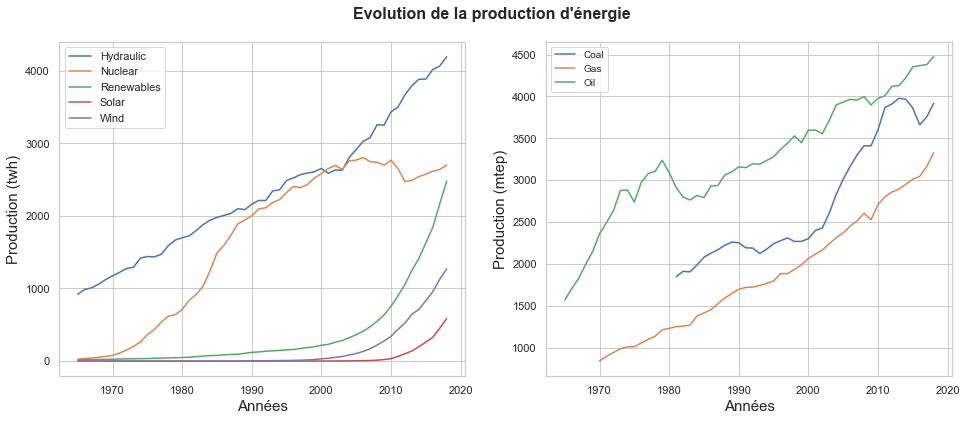

In [101]:
plt.close("all")
fig = plt.figure(figsize=(16, 6))
plt.subplots_adjust(top=0.90)
plt.suptitle("Evolution de la production d'énergie",
             fontsize=16, fontweight='bold')
sns.set(style='whitegrid')
plt.subplot(121)
sns.lineplot(x="Year", y="hydro_twh",
             data=databp[databp['Country'] == 'Total World'], label='Hydraulic')
sns.lineplot(x="Year", y="nuclear_twh",
             data=databp[databp['Country'] == 'Total World'], label='Nuclear')
sns.lineplot(x="Year", y="renewables_twh",
             data=databp[databp['Country'] == 'Total World'], label='Renewables')
sns.lineplot(x="Year", y="solar_twh",
             data=databp[databp['Country'] == 'Total World'], label='Solar')
sns.lineplot(x="Year", y="wind_twh",
             data=databp[databp['Country'] == 'Total World'], label='Wind')
plt.ylabel("Production (twh)", fontsize=15)
plt.xlabel("Années", fontsize=15)
plt.subplot(122)
sns.lineplot(x="Year", y="coalprod_mtoe",
             data=databp[databp['Country'] == 'Total World'], label='Coal')
sns.lineplot(x="Year", y="gasprod_mtoe",
             data=databp[databp['Country'] == 'Total World'], label='Gas')
sns.lineplot(x="Year", y="oilprod_mt",
             data=databp[databp['Country'] == 'Total World'], label='Oil')
plt.ylabel("Production (mtep)", fontsize=15)
plt.xlabel("Années", fontsize=15)
plt.legend(loc='upper left', prop={'size': 10})
plt.show()

<h2>B) Evolution des émissions de $CO_{2}$ et des températures dans le monde</h2>

* Etude des émissions de $CO_{2}$

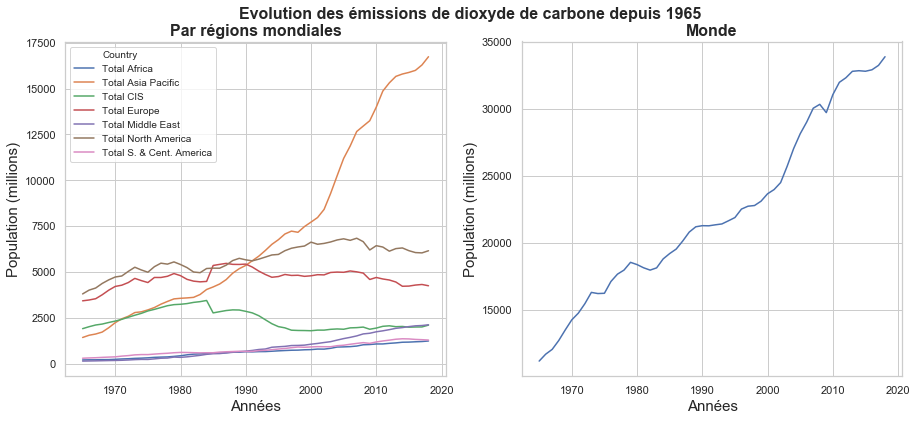

In [102]:
plt.close("all")
fig = plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=0.90)
plt.suptitle('Evolution des émissions de dioxyde de carbone depuis 1965',
             fontweight='bold', fontsize=16)
plt.subplot(121)
sns.set(style='whitegrid')
sns.lineplot(x="Year", y="co2_mtco2", hue="Country", data=table)
plt.title("Par régions mondiales", fontsize=16, fontweight='bold')
plt.xlabel("Années", fontsize=15)
plt.ylabel("Population (millions)", fontsize=15)
plt.legend(loc='upper left', prop={'size': 10})
plt.subplot(122)
sns.set(style='whitegrid',)
sns.lineplot(x="Year", y="co2_mtco2", hue="Country",
             data=databp[databp['Country'] == 'Total World'])
plt.title("Monde", fontsize=16, fontweight='bold')
plt.xlabel("Années", fontsize=15)
plt.ylabel("Population (millions)", fontsize=15)
plt.legend().set_visible(False)
plt.show()

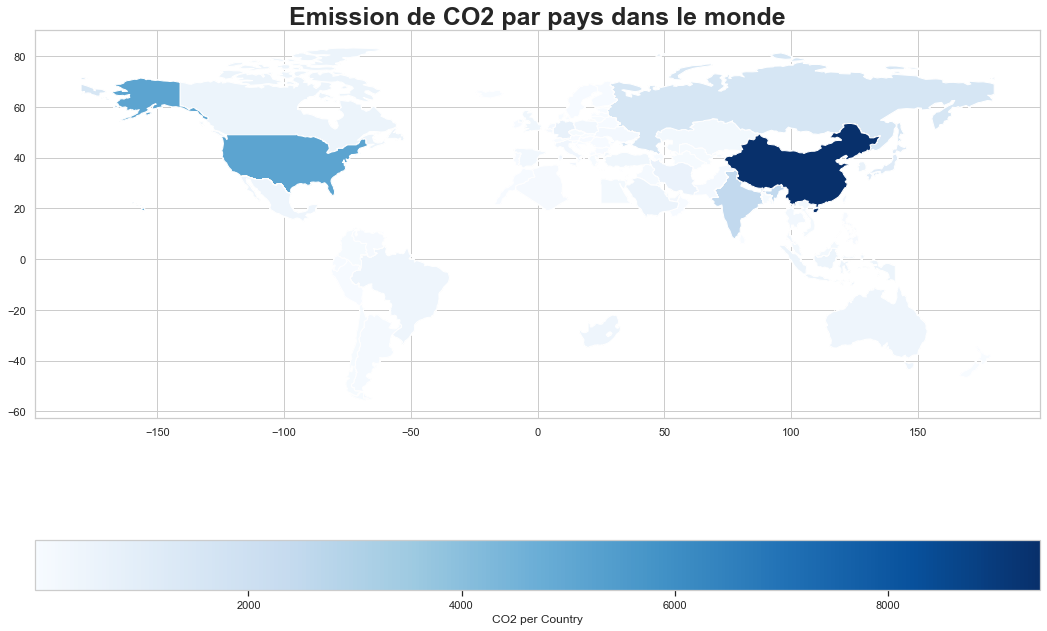

In [103]:
url = 'https://www.bp.com/content/dam/bp/business-sites/en/global/corporate/xlsx/energy-economics/statistical-review/bp-stats-review-2019-consolidated-dataset-panel-format.csv'
data = pd.read_csv(url)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
databis = data.rename(columns={'ISO3166_alpha3': 'iso_a3', })
test = world.merge(databis, on='iso_a3')[
    ['name', 'iso_a3', 'geometry', 'pop_est', 'co2_mtco2']]
test = test.dropna()

fig, ax = plt.subplots(1, 1, figsize=(18, 15))
plt.title("Emission de CO2 par pays dans le monde", fontsize=25, fontweight='bold')
test.plot(column='co2_mtco2', ax=ax, legend=True, cmap="Blues", figsize=(
    15, 15), legend_kwds={'label': "CO2 per Country", 'orientation': "horizontal"})

* Etude des temperatures

In [104]:
# get values from World Bank Climate API
api = wbpy.ClimateAPI()
iso_and_basin_codes = ["FIN"]
dataset = api.get_instrumental(data_type = "tas", interval = "year", locations = iso_and_basin_codes)
temp = list(dataset.as_dict().values())
temperatures = pd.Series(temp[0]).to_frame()
temperatures = temperatures.rename(columns={0: "FIN"})
iso_and_basin_codes = ["USA"]
dataset = api.get_instrumental(data_type = "tas", interval = "year", locations = iso_and_basin_codes)
temp = list(dataset.as_dict().values())
temp = list(temp[0].values())
temp = np.asarray(temp)
temperatures["USA"] = temp
iso_and_basin_codes = ["EGY"]
dataset = api.get_instrumental(data_type = "tas", interval = "year", locations = iso_and_basin_codes)
temp = list(dataset.as_dict().values())
temp = list(temp[0].values())
temp = np.asarray(temp)
temperatures["EGY"] = temp
iso_and_basin_codes = ["CHN"]
dataset = api.get_instrumental(data_type = "tas", interval = "year", locations = iso_and_basin_codes)
temp = list(dataset.as_dict().values())
temp = list(temp[0].values())
temp = np.asarray(temp)
temperatures["CHN"] = temp

In [105]:
temperatures["Year"] = temperatures.index
temp = temperatures.melt(id_vars="Year")
temp['Year'] = pd.to_datetime(temp['Year'], format='%Y')

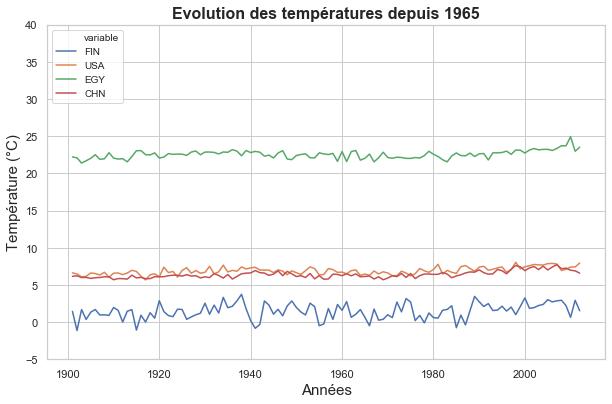

In [106]:
plt.close("all")
fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(top=0.90)
plt.title('Evolution des températures depuis 1965',
             fontweight='bold', fontsize=16)
sns.set(style='whitegrid')
sns.lineplot(x="Year", y="value", hue="variable", data=temp)
plt.xlabel("Années", fontsize=15)
plt.ylabel("Température (°C)", fontsize=15)
plt.legend(loc='upper left', prop={'size': 10})
plt.ylim(-5,40)
plt.show()

<h2>C) Focus sur la production et consommation de pétrole</h2>

In [107]:
temp_USA = temperatures[["Year", "USA"]]
temp_USA = temp_USA.melt(id_vars="Year")

In [108]:
liste = ['Year', 'oilprod_mt', 'oilcons_mtoe', '$ 2018']
table_USA = databp[databp['Country'] == 'Total North America'][liste]

In [109]:
table_USA['Year'] = pd.DatetimeIndex(table_USA['Year']).year
table_USA['Year'] = table_USA['Year'].apply(str)

In [110]:
table_USA_oil = temp_USA.merge(table_USA, on="Year")
table_USA_oil.rename(columns={'value' : 'temperature', 'oilprod_mt': 'production (mtep)', 'oilcons_mtoe' : 'consommation (mtep)', '$ 2018': 'price ($)'}, inplace=True)

<Figure size 1080x1080 with 0 Axes>

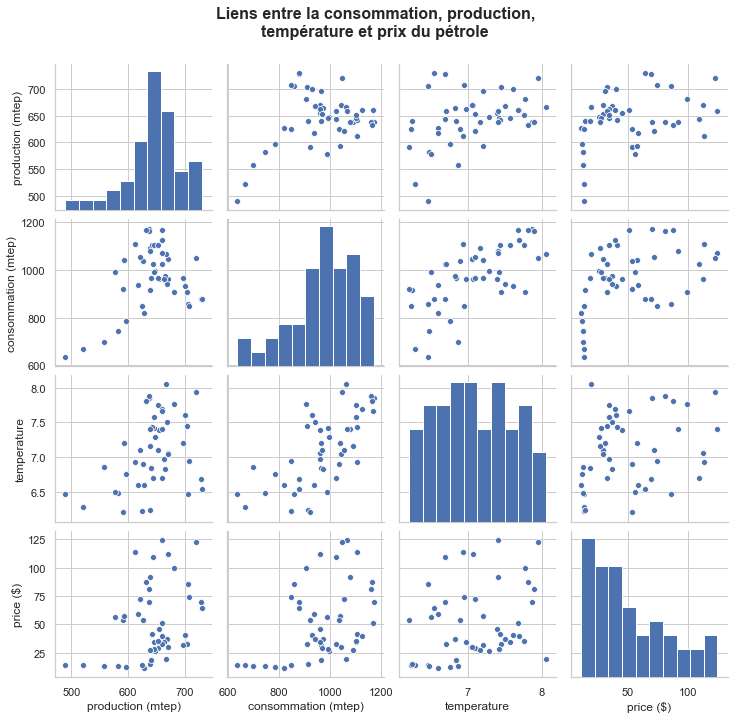

In [111]:
fig = plt.figure(figsize=(15, 15))
col = ["production (mtep)", "consommation (mtep)", "temperature", "price ($)"]
g = sns.pairplot(data=table_USA_oil[col])
plt.subplots_adjust(top=0.90)
g = g.fig.suptitle('Liens entre la consommation, production,\ntempérature et prix du pétrole', fontweight='bold', fontsize=16);

In [112]:
data = databp_price[databp_price["Country"] == "Total World"]
data = data[['Year', 'co2_mtco2', 'oilcons_mtoe', 'oilprod_mt', '$ 2018']].copy()
new_col = pd.read_csv("temp_nasa.csv")
new_col = new_col[new_col["1880"]>1964]
new_col = new_col[new_col["1880"]<2019]
data.head()
data = data.merge(new_col, how = "inner", left_on='Year', right_on = '1880')
data = data.set_index("Year")
data.drop('1880', axis = 1, inplace = True)
data = data.rename(columns={"co2_mtco2": "co2", "oilcons_mtoe": "oil_cons", "oilprod_mt": "oil_prod", "$ 2018": "oil_price", "-.29": "temp"})
data["co2"] = data["co2"]/1000
data["oil_cons"] = data["oil_cons"]/100
data["oil_prod"] = data["oil_prod"]/100
data["temp"] = data["temp"]*100

# convert to numpy
data_np = data.to_numpy()
# dimensions
T, n = data_np.shape

**Modélisation**

In [113]:
# nombre de retards dans le VAR
p = 2
# nombre de périodes de prévision
f_periods = 10

In [114]:
# generation des regresseurs
def gen_Y_X(data, p):
    T, n = data.shape
    k = n * p + 1
    X = np.zeros(shape=(T-p, k))
    for period in range(p, T):
        x = np.zeros(shape=(1, k))
        for lag in range(p):
            x[0, lag * n:(lag+1) * n] = data[period - lag - 1]
        x[0, k - 1] = 1
        X[period - p, :] = x
    Y = data[p:,:]
    return Y, X

In [115]:
Y, X = gen_Y_X(data_np, p)

In [116]:
# estimation du VAR
def ols_var(Y, X):
    B_hat = inv(np.transpose(X) @ X ) @ (np.transpose(X) @ Y)
    return B_hat

In [117]:
B_hat = ols_var(Y, X)

In [118]:
# estimation des prédictions
def pred_var(data, B_hat, p, f_periods):
    T, n = data.shape
    k = n * p + 1
    data_pred = np.zeros(shape=(T + f_periods, n))
    data_pred[:T,:] = data
    for f_period in range(f_periods):
        x = np.zeros(shape=(1, k))
        for lag in range(p):
            x[0, lag * n:(lag+1) * n] = data_pred[T + f_period - lag - 1]
        x[0, k - 1] = 1
        pred = x @ B_hat
        data_pred[T + f_period,:] = pred
    return data_pred      

In [119]:
data_pred = pred_var(data_np, B_hat, p, f_periods)

In [120]:
data_pred_pandas = pd.DataFrame({'co2': data_pred[:, 0], 'oil_cons': data_pred[:, 1], 'oil_prod': data_pred[:, 2], 'oil_price': data_pred[:, 3], 'temp': data_pred[:, 4]})

In [121]:
data_pred_pandas["Year"] = pd.Series(range(1965, 2029))

In [122]:
data_pred_pandas

,co2,oil_cons,oil_prod,oil_price,temp,Year
0,11.193939,15.542900,15.675873,14.310086,-8.000000,1965
1,11.708869,16.736687,17.022157,13.921372,-17.000000,1966
2,12.068148,17.934346,18.261755,13.528139,-6.000000,1967
3,12.725797,19.469656,19.922605,12.985747,-25.000000,1968
4,13.518792,21.109739,21.444791,12.321318,-11.000000,1969
...,...,...,...,...,...,...
59,36.928756,49.613429,47.067192,85.792904,94.515124,2024
60,37.399646,50.055825,47.430399,86.074587,96.968534,2025
61,37.884818,50.527196,47.839248,86.522827,98.851254,2026
62,38.368352,51.000417,48.256957,86.815663,100.482570,2027


In [123]:
data_pred_pandas["Year"] = data_pred_pandas["Year"].apply(str)
data_pred_pandas['Year'] = pd.to_datetime(data_pred_pandas['Year'], format='%Y')

In [124]:
data_pred_pandas.columns

Index(['co2', 'oil_cons', 'oil_prod', 'oil_price', 'temp', 'Year'], dtype='object')

In [125]:
data_pred_pandas.rename(columns={'co2': 'Emission CO2', 'oil_cons': 'Consommation pétrole (mtep)', 'oil_prod': 'Production pétrole (mtep)', 'oil_price': 'Prix pétrole ($)',
                               'temp': 'Température'}, inplace=True)
data_pred_pandas = data_pred_pandas.melt(id_vars=['Year'])

In [126]:
data_pred_pandas

,Year,variable,value
0,1965-01-01,Emission CO2,11.193939
1,1966-01-01,Emission CO2,11.708869
2,1967-01-01,Emission CO2,12.068148
3,1968-01-01,Emission CO2,12.725797
4,1969-01-01,Emission CO2,13.518792
...,...,...,...
315,2024-01-01,Température,94.515124
316,2025-01-01,Température,96.968534
317,2026-01-01,Température,98.851254
318,2027-01-01,Température,100.482570


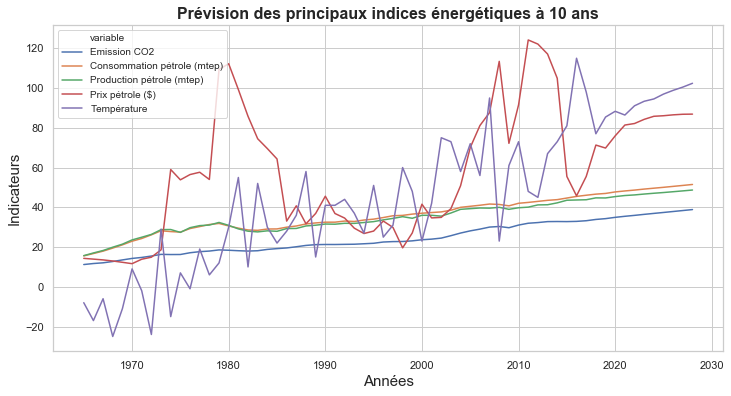

In [127]:
plt.close("all")
fig = plt.figure(figsize=(12, 6))
sns.set(style='whitegrid')
sns.lineplot(x="Year", y="value", hue='variable',
             data=data_pred_pandas)
plt.title("Prévision des principaux indices énergétiques à 10 ans",
          fontsize=16, fontweight='bold')
plt.xlabel("Années", fontsize=15)
plt.ylabel("Indicateurs", fontsize=15)
plt.legend(loc='upper left', prop={'size': 10})
plt.show()

<h1>II. Perspectives sur les énergies de demain</h1>

In [128]:
#import du dataset des investissements par pays par 
dataRD = pd.read_excel('https://webstore.iea.org/Content/Images/uploaded/IEA_Energy_RDD_selected_data.xls',sheet_name='RDD Country Budget')

In [129]:
#remplacer le header par la bonne ligne
new_header = dataRD.iloc[0] #grab the first row for the header
dataRD = dataRD[1:] #take the data less the header row
dataRD.columns = new_header #set the header row as the df header

In [130]:
#conserver la ligne correspondant à la devise recherchée
dataRD = dataRD[dataRD['Currency'].isin(['USD (2018 prices and PPP)'])]
#filtrer sur les pays faisant partie de l'IEA 
dataRD = dataRD[dataRD['Country'].isin(['Australia', 'Austria', 'Belgium', 'Canada', 'Czech Republic','Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece','Hungary', 'Ireland', 'Italy', 'Japan', 'Korea', 'Luxembourg','Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland','Portugal', 'Slovak Republic', 'Spain', 'Sweden', 'Switzerland','Turkey', 'United Kingdom', 'United States'])]
#rendre le dataset "tidy"
dataRD2 = dataRD.melt(id_vars=['Country','Currency','Economic Indicators'],var_name='Year')
#remplacer les valeurs non exploitables
dataRD2 = dataRD2.replace(to_replace ="..", value ="0") 
#donner des noms de colonnes clean
dataRD2.columns = ['Country', 'Currency', 'Economic Indicators', 'Year','Value']
#clean des espaces après le nom des énergies
dataRD2['Economic Indicators']= dataRD2['Economic Indicators'].str.rstrip()
#df['DataFrame Column'] = pd.to_numeric(df['DataFrame Column'],errors='coerce')
dataRD2['Value'] = pd.to_numeric(dataRD2['Value'],errors='coerce')
#groupe l'information par année et par source d'énergie
dataRD2 = dataRD2.groupby(['Year','Economic Indicators']).sum()
#dropper l'index automatique
dataRD3 = dataRD2.reset_index()
#mettre la data sous le bon format pour pouvoir faire un stacked bar chart
dataRD4 = dataRD3.pivot(index = "Year",columns="Economic Indicators",values="Value")
#drop d'une colonne inutile
dataRD4 = dataRD4.drop(columns = ['Total Budget'])

<Figure size 432x288 with 0 Axes>

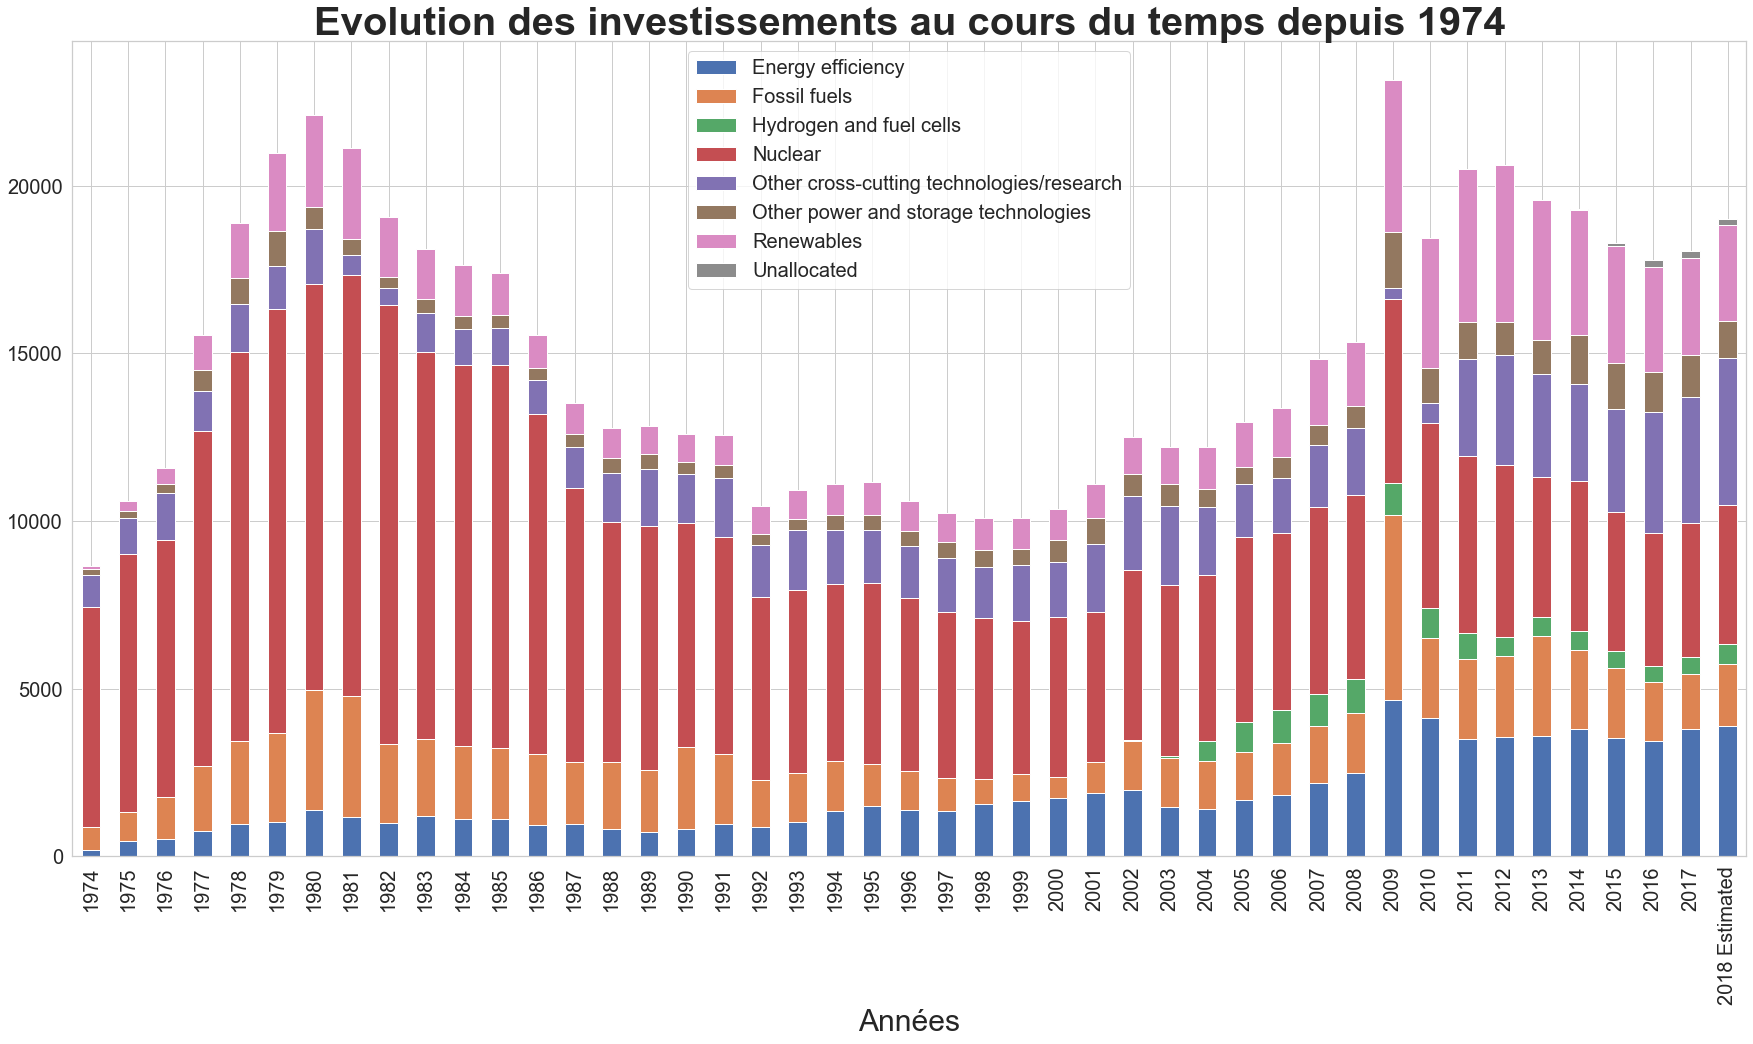

In [131]:
plt.close('all')
plt.figure()
dataRD4.plot(figsize=(30,15),kind='bar',stacked=True)
plt.title('Evolution des investissements au cours du temps depuis 1974',
             fontweight='bold', fontsize=40)
plt.xlabel("Années", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
plt.show()

Les investissements dans les énergies fossiles ont progressivement diminué jusque dans les années 2000. Depuis, nous notons une augmentation de la recherche dans avec une stabilisation qui nous laisse penser que les énergies fossiles garderont une importance forte à court et moyen terme. 

Depuis 2004, il est à noter l'apparition de la recherche dans l'énergie Hydrogène qui constitue l'un des espoirs de l'énergie de demain. 

Si le nucléaire constituait dans les années 70 et 80 une énergie au centre de l'attention des gouvernements suite aux différents incidents (Tchernobyl en 1987, et FUkushima en 2011) nous notons une baisse forte des investissements dans ce domaine, ce qui laisse à penser que le nucléaire ne jouera pas le rôle d'énergie de transition. 

Ce qui est à noter est qu'une forte part des investissements est réalisée non pas dans la recherche pure de nouvelles sources d'énergies, mais plutôt dans les technologies d'économie ou bien d'optimisation d'énergie. 

Enfin, depuis les années 2008, nous pouvons voir que les efforts de recherche se sont portés sur les énergies renouvelables et constituent aujourd'hui le 4ème poste de dépenses. 